---
title: "Download Imagery and Segmentation"
aliases:
    - ../programmatic_access/em_py_04_imagery_segmentation.html
draft: false
format: 
    html:
        toc: true 
        code-fold: false
        code-links:
          - text: Download Quickstart Notebooks
            icon: file-code
            href: https://github.com/AllenInstitute/microns_tutorial/tree/main/tutorial_book/quickstart_notebooks
execute:
    eval: False
    warning: False
jupyter: python3
bibliography: [../references.bib]
---

## Connected morphological representations: segmentation

The electron microscopy images and their dense reconstruction into 3D objects (respectively: imagery and segmentation) are available to download through the python client [cloud-volume](https://github.com/seung-lab/cloud-volume). 

{{< include _morphological_representations.qmd >}}

## Cloud-Volume for downloading imagery, segmentation
CloudVolume is a serverless Python client for random access reading and writing of [Neuroglancer](https://github.com/google/neuroglancer/) volumes in ["Precomputed"](https://github.com/google/neuroglancer/tree/master/src/datasource/precomputed#readme) format, a set of representations for arbitrarily large volumetric images, meshes, and skeletons.

Precomputed volumes are typically stored on AWS S3, Google Storage, or locally. CloudVolume can read and write to these object storage providers given a service account token with appropriate permissions. However, these volumes can be stored on any service, including an ordinary webserver or local filesystem, that supports key-value access.

[cloud-volume](https://github.com/seung-lab/cloud-volume/) is the mechanism for many programmatic data queries, and integrates heavily with the CAVE ecosystem but is distinct. You can install cloud-volume with:

```python
pip install cloud-volume
```

The **Connectome Annotation Versioning Engine (CAVE)** is a suite of tools developed at the Allen Institute and Seung Lab to manage large connectomics data.  

::: {.callout-important}
## Initial Setup
Before using any programmatic access to the data, [you first need to set up your CAVEclient token](01-caveclient-setup.html). When `CAVEclient` saves the token to your local machine, `cloudvolume` will access the same token.
:::

In [1]:
from caveclient import CAVEclient
from cloudvolume import CloudVolume

datastack_name = 'minnie65_public'
client = CAVEclient(datastack_name)

The datastack includes information about the imagery and segmentation source, and can provide that information when prompted

In [2]:
client.info.image_source()

'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'

In [3]:
client.info.segmentation_source()

'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public'

In [4]:
# this can be used to initialize a cloudvolume object
cv = CloudVolume(client.info.segmentation_source(), progress=False, use_https=True)

### Examples from the cloudvolume README:

```python
image = cv[:,:,:] # Download the entire image stack into a numpy array
image = cv.download(bbox, mip=2, renumber=True) # download w/ smaller dtype
image = cv.download(bbox, mip=2, label=777) # download binary image for label

uniq = cv.unique(bbox, mip=0) # efficient extraction of unique labels
listing = cv.exists( np.s_[0:64, 0:128, 0:64] ) # get a report on which chunks actually exist
exists = cv.image.has_data(mip=0) # boolean check to see if any data is there
listing = cv.delete( np.s_[0:64, 0:128, 0:64] ) # delete this region (bbox must be chunk aligned)

img = cv.download_point( (x,y,z), size=256, mip=3 ) # download region around (mip 0) x,y,z at mip 3
pts = cv.scattered_points([ (x1,y1,z1), (x2,y2,z2) ]) # download voxel labels located at indicated points

# download image files without decompressing or rendering them. Good for caching!
files = cv.download_files(bbox, mip, decompress=False)
```

## ImageryClient for aligned downloads
We recommend using [ImageryClient](https://github.com/AllenInstitute/ImageryClient) for simple download imagery and segmentation data, like for generating figures. ImageryClient makes core use of [cloud-volume](https://github.com/seung-lab/cloud-volume/), but adds convenience and better integration with the CAVEclient.

You can install ImageryClient with:

```python
pip install imageryclient
```

ImageryClient is designed to download aligned blocks of imagery and segmentation data, as well as has some convenience functions for creating overlays of the two.

Imagery is downloaded as blocks of 8-bit values (0-255) that indicate grayscale intensity, while segmentation is downloaded as blocks of 64-bit integers that describe the segmentation ID of each voxel.

Alternatively, segmentation can be kept as a dictionary of boolean masks, where each key is a root ID and each value is a boolean mask of the same shape as the imagery.

Detailed information on the options can be found in the [documentation](https://github.com/AllenInstitute/ImageryClient).

A typical example would be to use ImageryClien to download and visualize a 512x512 pixel cutout of imagery and segmentation centered on a specific location based on the coordinates in Neuroglancer:

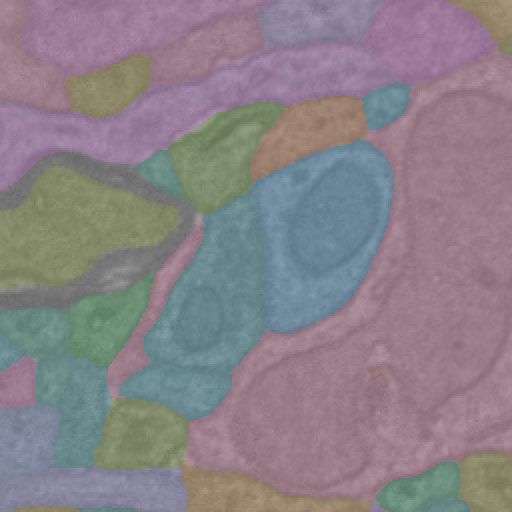

In [5]:
import imageryclient as ic

img_client = ic.ImageryClient(client=client)

ctr = [240640, 207872, 21360]

image, segs = img_client.image_and_segmentation_cutout(ctr,
                                                       split_segmentations=True,
                                                       bbox_size=(512, 512),
                                                       scale_to_bounds=True,
)

ic.composite_overlay(segs, imagery=image, palette='husl').convert("RGB")

# Note: the final `.convert('RGB')` is needed to build this documetnation, but is not required to run locally.